# See how sensitive the prediction at s[51] is on Y[50]

In [1]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

/Users/liy0h/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


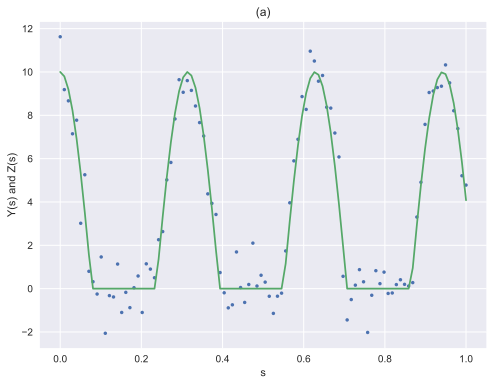

In [45]:
# Generate a dataset
N = 100
s = np.linspace(0,1,N).reshape(-1,1)
Y = 10 * np.cos(20 * s)
Y[Y<0] = 0
np.random.seed(1)
Z = np.random.normal(Y,1, size=(N,1))
plt.plot(s,Z,".")
plt.plot(s,Y)
plt.title("(a)")
plt.xlabel("s")
plt.ylabel("Y(s) and Z(s)")
#plt.show()
plt.savefig("nonlinear_z.pdf")

In [14]:
def create_mlp(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim = feature_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

In [15]:
num_basis = [10,19,37,73]
knots = [np.linspace(0,1,i) for i in num_basis]
##Wendland kernel
K = 0 ## basis size
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/num_basis[res]*2.5
    for i in range(num_basis[res]):
        d = np.absolute(s-knots[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

In [16]:
phi.shape

(100, 139)

In [17]:
model = create_mlp(feature_dim = K)
model.fit(phi,Z, validation_split = 0, epochs = 200, batch_size = 32, verbose = 0)
pred = model.predict(phi)

In [18]:
kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
m = GPy.models.GPRegression(s, Z, kernel)
m.optimize()
GP_pred,GP_var=m.predict(s)

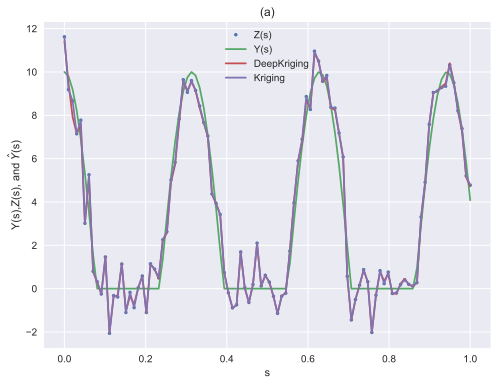

In [92]:
plt.plot(s,Z,".",label="Z(s)")
plt.plot(s,Y,label="Y(s)")
plt.plot(s,pred,label="DeepKriging")
plt.plot(s,GP_pred,label="Kriging")
plt.legend(loc='best')
plt.title("(a)")
plt.xlabel("s")
plt.ylabel("Y(s),Z(s), and $\hatY$(s)")
#plt.show()
plt.savefig("pred_y.pdf")

In [104]:
i = 50
j = 51
M = 50
z_50 = np.linspace(Z.min(),Z.max(),M).reshape(-1,1)
pred_GP = np.zeros(M)
pred_DK = np.zeros(M)
nr = 20

In [105]:
for k in range(M):
    Z_2 = np.delete(Z,j,0)
    phi_2 = np.delete(phi,j,0)
    s_2 = np.delete(s,j,0)
    Z_2[i] = z_50[k]
    for rep in range(nr):
        ## Calculate the average of nr deepKriging results to avoid the random batches.
        model.fit(phi_2,Z_2, epochs = 200, batch_size = 32, verbose = 0)
        pred_DK[k] = pred_DK[k] + model.predict(phi)[j]/nr
    m = GPy.models.GPRegression(s_2, Z_2, kernel)
    m.optimize()
    mean,var = m.predict(s)
    pred_GP[k] = mean[j]

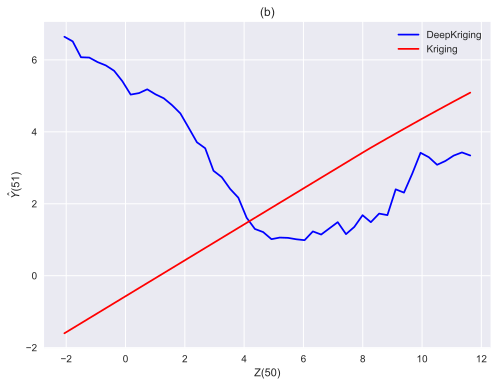

In [106]:
plt.plot(z_50, pred_DK,"b",label="DeepKriging")
plt.plot(z_50, pred_GP,"r",label="Kriging")
pylab.legend(loc='best')
plt.title("(b)")
plt.xlabel("Z(50)")
plt.ylabel("$\hat{Y}$(51)")
#plt.show()
plt.savefig("pred_z.pdf")